# optimising server utilisation
The goal is to create a diagram showing the optimal server utilisation as a percentage of the time active based on all given system parameters.

## calculating the hourly server price
The hourly server price for given parameters will be written as:
$$\boxed{C_{\text{tot}}=\frac{n_{\text{servers at 100\%}}}{\varepsilon_{\text{utilisation}}}\cdot\left[C_{\text{server per hour}} + W_{\text{base}} \cdot c_{\text{total per MWh}} + W_{\text{active}} \cdot c_{\text{max fee}} + W_{\text{active}} \cdot \left(c_{\text{grid per MWh}} + c_{\text{per MWh}}\right) \cdot \varepsilon_{\text{utilisation}} + C_{\text{grid base}}\right]}$$
where<p>
- $\varepsilon_{\text{utilisation}}$: utilisation of the servers (percentage of time active)
- $C$: Cost €/h (server rent (base price), base grid fee)
- $W$: Energy / MW (server while inactive, server while active)
- $c$: Cost / €/MWh (price per energy, consumption dependent grid fee)

Simplify the equation to:
$$\frac{C_{\text{tot}}}{n_{\text{servers at 100\%}}}=\alpha\cdot c_{\text{per MWh}} + \frac{\beta}{\varepsilon_{\text{utilisation}}} + \gamma$$
which can be optimised based on the given summands. These can represent the following variables:
- $\alpha = W_{\text{active}}$
- $\beta = C_{\text{server per hour}} + W_{\text{base}} \cdot c_{\text{total per MWh}} + W_{\text{active}} \cdot c_{\text{max fee}} + C_{\text{grid base}}$
- $\gamma = W_{\text{active}} \cdot c_{\text{grid per MWh}}$

Now we may define the total hourly cost of the servers while inactive as:
$C_{\text{server per hour}} + W_{\text{base}} \cdot c_{\text{total per MWh}} + C_{\text{grid base}} := C_{\text{total base}}$

$\gamma$ is negligible for finding the minimal price based on a given price per energy consumed and utilisation of the servers due to it being an additive constant. Therefore the set of functions that needs to be optimised (as in analysed for local minima) are expressed as:
$$\boxed{f_{W_{\text{active}}, C_{\text{total base}}, c_{\text{max fee}}}\left(c_{\text{per MWh}}, \varepsilon_{\text{utilisation}}\right)=W_{\text{active}}\cdot c_{\text{per MWh}} + \frac{C_{\text{total base}} + W_{\text{active}}\cdot c_{\text{max fee}}}{\varepsilon_{\text{utilisation}}}}$$

The arguments of the function will be determined as pairs through the price data while its parameters are system dependent. Thus, different values for the parameters should be tested within a reasonable order of magnitude. One must note that these values only correspond to one server.

$O(W_{\text{active}})=10^{-3}MW$


$O(C_{\text{total base}})=10^{-1}€/h$


$c_{\text{max fee}}\approx 16.7\ €/MW/h$ (see https://www.bonn-netz.de/fileadmin/dokumente/Unser_Netz/20250120_Preisblatt_Strom_2025_final.pdf)

The diagram will therefore depend on two parameters and be a 3d surface plot.

## import libraries and fetch data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# uncomment for interactive 3d plot
#%matplotlib qt

import requests
import json

import os
import datetime
import time

In [2]:
fetch = False
days = 365
end = int(time.time())
start = end - 86400 * days

if fetch or not os.path.exists("price.json"):
    price = "https://api.energy-charts.info/price?country=de&start=" + str(start) + "&end=" + str(end)
    response = requests.get(price)
    if response.status_code == 200:
        price_data = response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
    with open("price.json", "w") as f:
        json.dump(response.json(), f, indent=4)
else:
    with open("price.json", "r") as f:
        price_data = json.load(f)

timestamps = [pt for pt in price_data['unix_seconds']]
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
price_data = [pt for pt in price_data['price']]

## implementation of the derived functions

In [3]:
def server_cost(utilisation,
                          price_per_mwh, server_cost_per_hour,
                          server_base_consumption_mwh, server_active_consumption_mwh,
                          grid_fee_base=0, grid_fee_per_mwh=0, grid_fee_max=0, 
                          server_capacity_to_required_capacity=1):
    base_cost = server_cost_per_hour * server_capacity_to_required_capacity / utilisation
    base_consumption_cost = server_base_consumption_mwh * price_per_mwh * server_capacity_to_required_capacity / utilisation
    max_consumption_cost = grid_fee_max * server_active_consumption_mwh * server_capacity_to_required_capacity / utilisation
    active_consumption_cost = (grid_fee_per_mwh + price_per_mwh) * server_active_consumption_mwh * server_capacity_to_required_capacity
    return base_cost + base_consumption_cost + active_consumption_cost + max_consumption_cost + grid_fee_base

def opt_cost(utilisation, price_per_mwh, active_consumption, total_base_cost, grid_max_fee):
    return active_consumption * price_per_mwh + (total_base_cost + active_consumption * grid_max_fee)/ utilisation 

## obtain price per consumed energy - utilisation datapoints
In order to obtain the price per consumed energy for a given utilisation the time - price per consumed energy - chart will be used. A threshold is set above which the servers must not be running. The Quotient of the time the price per consumed energy is below the threshold and the total time interval of the data then represents the utilisation. By numerically integrating over the price per consumed energy for each price value below the threshold through approximation of rectangles one may followingly find the mean price per consumed energy for a given threshold and therefore a specific utilisation. As $\frac{d\,f_{W_{\text{active}}, C_{\text{total base}}, c_{\text{max fee}}}\left(c_{\text{per MWh}}, \varepsilon_{\text{utilisation}}\right)}{d\,c_{\text{per MWh}}}=\text{const.}$, one may integrate over the price per consumed energy instead of integrating over the value of the function $f$.

In [4]:
probe_price = np.linspace(0, max(price_data), 100)
utilisation = np.ndarray((len(probe_price)))
price_sum = np.ndarray((len(probe_price)))
time_delta = timestamps[len(timestamps) - 1] - timestamps[0]

for n, probe in enumerate(probe_price):
    t_auslastung = 0
    price_times_dt = 0
    for i in range(1, len(price_data) - 1):
        if price_data[i] <= probe:
            dt = ((timestamps[i+1] - timestamps[i]) + (timestamps[i] - timestamps[i-1])) / 2
            t_auslastung += dt
            price_times_dt += dt * price_data[i]
    utilisation[n] = t_auslastung / time_delta
    price_sum[n] = price_times_dt / t_auslastung

## show example utilisation - price per consumed energy - graph

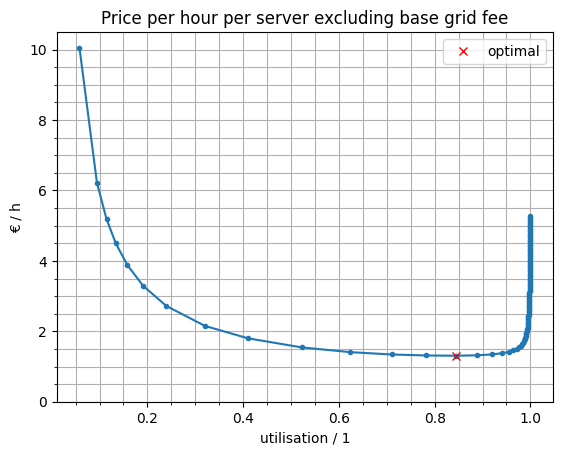

Optimal utilisation: 84.36%
Savings relative to 100% utilisation: 75.19%


In [5]:
oc = opt_cost(utilisation, probe_price, 5e-3, 0.5, 16.7)
plt.plot(utilisation, oc, ".-")
plt.plot(utilisation[np.argmin(oc)], np.min(oc), "rx", label="optimal")
plt.title("Price per hour per server excluding base grid fee")
plt.xlabel("utilisation / 1")
plt.ylabel("€ / h")
plt.ylim(0)
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.legend()
plt.show()

print(f"Optimal utilisation: {utilisation[np.argmin(oc)]:.2%}\nSavings relative to 100% utilisation: {(1 - np.min(oc) / oc[-1]):.2%}")

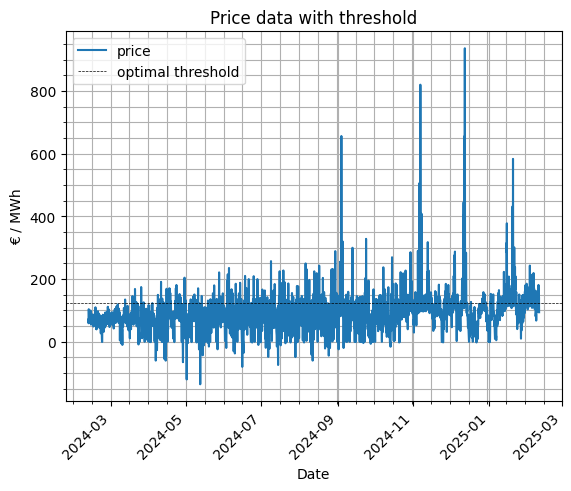

In [6]:
plt.plot(dates, price_data, label="price")
plt.title("Price data with threshold")
plt.xlabel("Date")
plt.ylabel("€ / MWh")
plt.grid(visible=True, which='both', axis='both')
plt.xticks(rotation=45, ha='right')
plt.axhline(probe_price[np.argmin(oc)], color='black', linestyle='--', linewidth=0.5, label="optimal threshold")
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.legend()
plt.show()

## calculate utilisation, threshold and lowest mean for the given range of function parameters

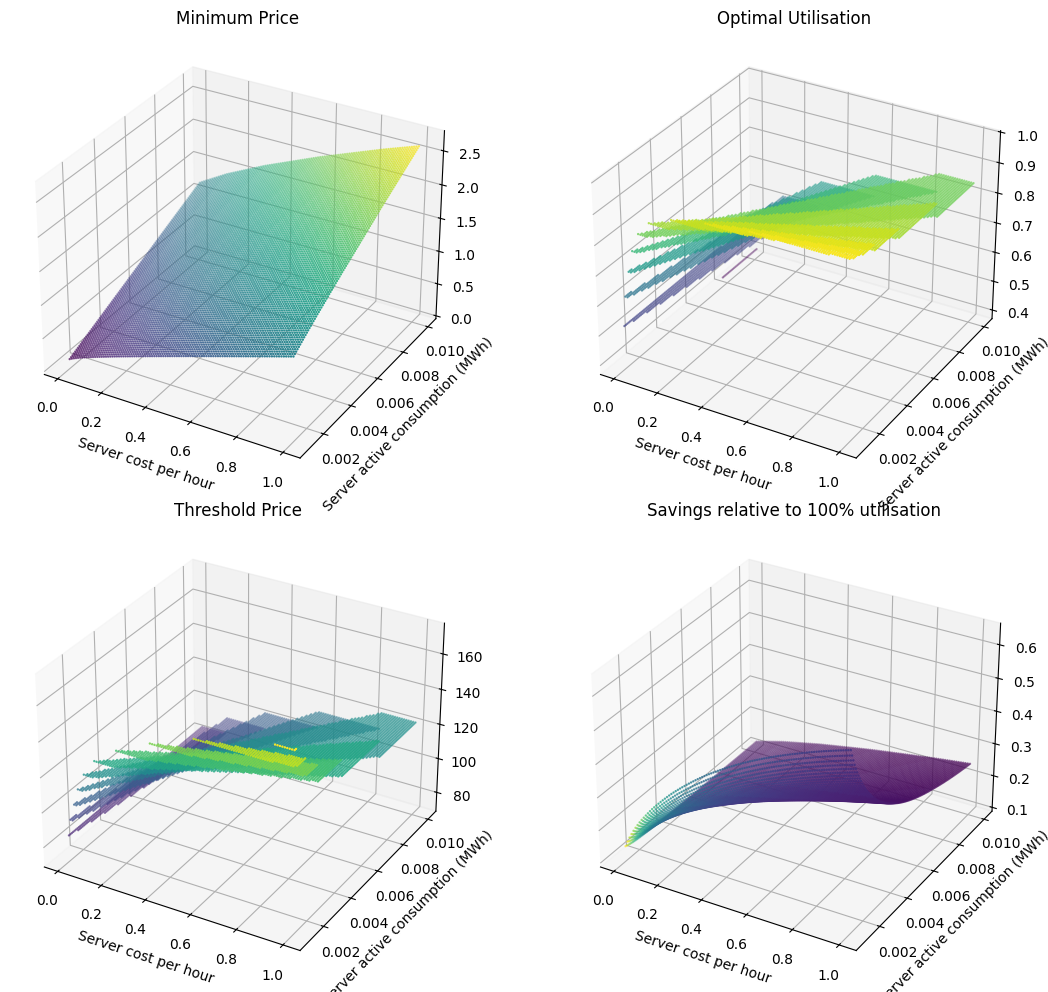

In [7]:
grid_max_fee = 16.7
server_cost_per_hour = np.linspace(0.01, 1, 100)
server_active_consumption_mwh = np.linspace(1e-3, 10e-3, 100)

min_price = np.ndarray((len(server_cost_per_hour), len(server_active_consumption_mwh)))
normal_price = np.ndarray((len(server_cost_per_hour), len(server_active_consumption_mwh))) # at 100% utilisation
opt_utilisation = np.ndarray((len(server_cost_per_hour), len(server_active_consumption_mwh)))
threshold = np.ndarray((len(server_cost_per_hour), len(server_active_consumption_mwh)))

for i, cost in enumerate(server_cost_per_hour):
    for j, consumption in enumerate(server_active_consumption_mwh):
        price_list = opt_cost(utilisation, probe_price, consumption, cost, grid_max_fee)
        min_price[i, j] = min(price_list)
        normal_price[i, j] = price_list[-1]
        opt_utilisation[i, j] = utilisation[np.argmin(price_list)]
        threshold[i, j] = probe_price[np.argmin(price_list)]

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')
X, Y = np.meshgrid(server_cost_per_hour, server_active_consumption_mwh, indexing='ij')

ax1.scatter(X.flatten(), Y.flatten(), min_price.flatten(), c=min_price.flatten(), cmap='viridis', s=0.5)
ax1.set_title("Minimum Price")
ax1.set_xlabel("Server cost per hour")
ax1.set_ylabel("Server active consumption (MWh)")

ax2.scatter(X.flatten(), Y.flatten(), opt_utilisation.flatten(), c=opt_utilisation.flatten(), cmap='viridis', s=0.5)
ax2.set_title("Optimal Utilisation")
ax2.set_xlabel("Server cost per hour")
ax2.set_ylabel("Server active consumption (MWh)")

ax3.scatter(X.flatten(), Y.flatten(), threshold.flatten(), c=threshold.flatten(), cmap='viridis', s=0.5)
ax3.set_title("Threshold Price")
ax3.set_xlabel("Server cost per hour")
ax3.set_ylabel("Server active consumption (MWh)")

ax4.scatter(X.flatten(), Y.flatten(), min_price.flatten() / normal_price.flatten(), c=threshold.flatten() / min_price.flatten(), cmap='viridis', s=0.5)
ax4.set_title("Savings relative to 100% utilisation")
ax4.set_xlabel("Server cost per hour")
ax4.set_ylabel("Server active consumption (MWh)")

plt.tight_layout()
plt.show()